In [1]:
import numpy as np
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score


import gensim
from gensim.models import Word2Vec

In [2]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## Carga de datos y preparación

In [4]:
train_df = pd.read_excel("./data/cat_6716.xlsx")

In [5]:
train_df.shape

(3000, 2)

In [6]:
train_df.sample(10)

,Textos_espanol,sdg
874,El recuadro 3.1 proporciona un modelo conceptu...,6
2658,La administración policial se refiere al contr...,16
1158,Aunque el gasto de Aspen Snowmass en el produc...,7
1402,"Por ejemplo, en la EUR (European Utilities Req...",7
2680,Las sanciones selectivas adoptadas por el Cons...,16
1208,Pero también es importante considerar qué otro...,7
165,"En primer lugar, las preocupaciones sobre el d...",6
2617,Los programas de cámaras corporales policiales...,16
52,También hay algunas regiones donde las fuentes...,6
803,Target 6d recomienda reciclar o tratar todas l...,6


In [7]:
train_df.dtypes

Textos_espanol    object
sdg                int64
dtype: object

In [8]:
train_df["Textos_espanol"]= train_df["Textos_espanol"].astype(str)

In [9]:
test_df = pd.read_excel("./data/SinEtiquetatest_cat_6716.xlsx")

In [10]:
test_df

,Textos_espanol,sdg
0,1. 1. Introducción: Las Estructuras del Derech...,NaN
1,Las aguas subterráneas se han debatido en el c...,NaN
2,La presente contribución evalúa la jurispruden...,NaN
3,"Sin embargo, este crédito fiscal expira en 201...",NaN
4,"Este estudio explora las actitudes, comportami...",NaN
...,...,...
975,Este artículo explora la historia y el impacto...,NaN
976,Mientras que algunos dan mayor énfasis a la ma...,NaN
977,Una innovación importante para garantizar el s...,NaN
978,El Salvador continúa luchando con niveles elev...,NaN


## Preparacion de los datos

Se pasa todo a minusculas y se eliminan signos de puntuacion y caracteres especiales para facilitar el procesamiento de las palabras

In [11]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower()
    text=text.strip()
    text=re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text)
    text = re.sub(r'\s+',' ',text)
    return text


Tambien se remueven "Stop words" o palabras genericas que no afectan el sentimieno general en el texto

In [12]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stop_words]
    return ' '.join(a)

Se utiliza la lematizacion para reducir palabras a su estado mas basico removiendo conjugaciones

In [13]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [14]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

Tomado de https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

In [15]:
train_df['clean_text'] = train_df['Textos_espanol'].apply(lambda x: finalpreprocess(x))
train_df.head()

,Textos_espanol,sdg,clean_text
0,"Es importante destacar que, en un año de sequí...",6,importante destacar año sequía espera disminuy...
1,Hay una gran cantidad de literatura sobre Aust...,6,gran cantidad literatura australia área sugier...
2,"Los procesos de descentralización, emprendidos...",6,procesos descentralización emprendidos serie a...
3,Esto puede tener consecuencias sustanciales pa...,6,puede tener consecuencias sustanciales calidad...
4,La función de beneficio también incorpora pará...,6,función beneficio incorpora parámetros afectan...


## Vectorizacion

Para que los modelos de clasificacion puedan trabajar con los datos es importante darles valores numericos primero

### Division de datos de entranamiento en entranamineto y prueba

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_df["clean_text"],train_df["sdg"],test_size=0.2,shuffle=True)

In [17]:
X_train_tok= [nltk.word_tokenize(i) for i in X_train]
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

convertimos los textos tokenizados en representaciones vectoriales promedio basadas en Word2Vec

In [18]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
train_df['clean_text_tok']=[nltk.word_tokenize(i) for i in train_df['clean_text']]
model = Word2Vec(train_df['clean_text_tok'],min_count=1)
w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))
modelw = MeanEmbeddingVectorizer(w2v)

In [19]:
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_test_tok)

In [20]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model
#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)
y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

unique, counts = np.unique(y_predict, return_counts=True)
dict(zip(unique, counts))

              precision    recall  f1-score   support

           6       0.94      0.89      0.91       203
           7       0.94      0.91      0.93       187
          16       0.91      0.99      0.95       210

    accuracy                           0.93       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.93      0.93      0.93       600

Confusion Matrix: [[180  10  13]
 [  9 170   8]
 [  3   0 207]]


{6: 192, 7: 180, 16: 228}

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label = 16)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

AUC: 0.1868376068376068


Algoritmo: Arboles de desicion.

In [22]:
tfidf_model = DecisionTreeClassifier(random_state = 1)

In [23]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [25]:
X_tfidf = tfidf.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
tfidf_model.fit(X_tfidf, y_train)

DecisionTreeClassifier(random_state=1)

<Axes: >

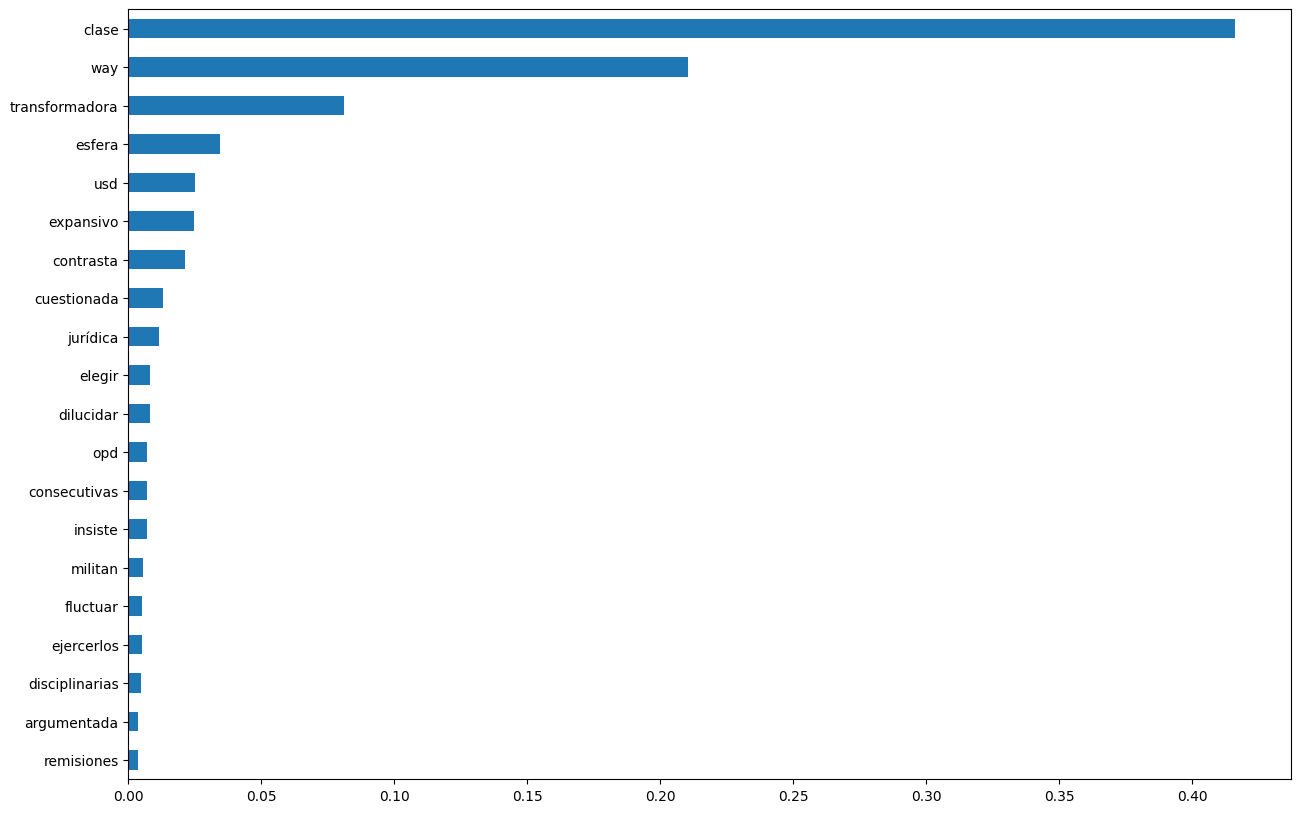

In [27]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [30]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test))

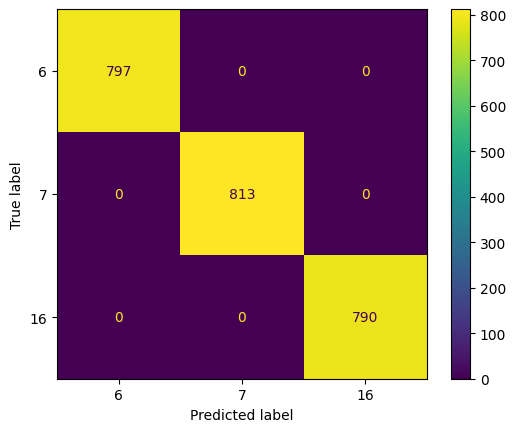

In [31]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

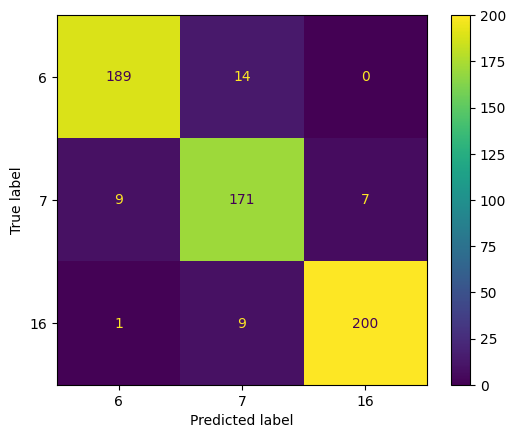

In [32]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [35]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print("Recall:", recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print("F1:", f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [36]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict, average="weighted"))
print("Recall:", recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print("F1:", f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.9342124043445476
Recall: 0.9333333333333333
F1: 0.9336295227538735
